# Comparison of Accelerated Stochastic Gradient Descent Methods

In this document, we compare the relative utilities of different *accelerated SGD* methods. We compare the following methods:



- SGD - $ \theta^{t+1} = \theta^t - \eta \nabla_{\theta} l_t(\theta^t) $. 

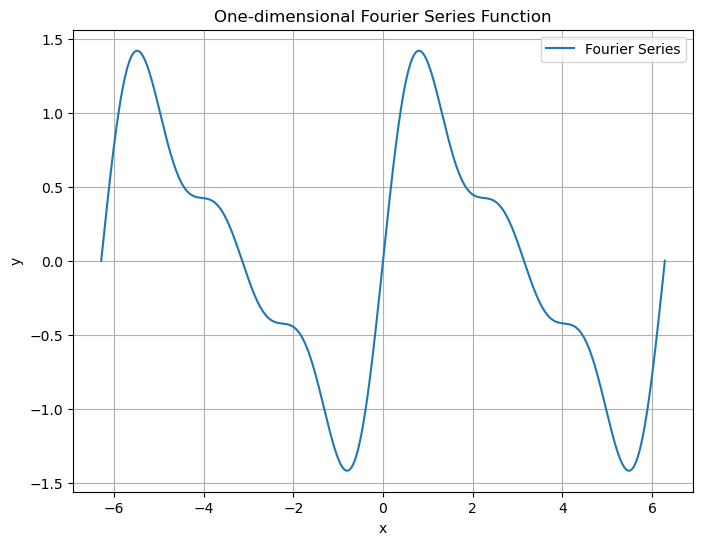

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Fourier series coefficients (amplitudes and frequencies)
def fourier_series(x, coefficients):
    n = len(coefficients)
    result = 0.0
    for i in range(n):
        amplitude, frequency = coefficients[i]
        result += amplitude * np.sin(frequency * x)
    return result

# Input Fourier series coefficients (amplitudes and frequencies)
# Example coefficients: [(amplitude_1, frequency_1), (amplitude_2, frequency_2), ...]
coefficients = [(1.0, 1.0), (0.5, 2.0), (0.3, 3.0)]  # Example Fourier series

# Generate x values for plotting
x_values = np.linspace(-2*np.pi, 2*np.pi, 1000)  # Range of x values

# Calculate y values using Fourier series
y_values = np.array([fourier_series(x, coefficients) for x in x_values])

# Plot the Fourier series function
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='Fourier Series')
plt.title('One-dimensional Fourier Series Function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

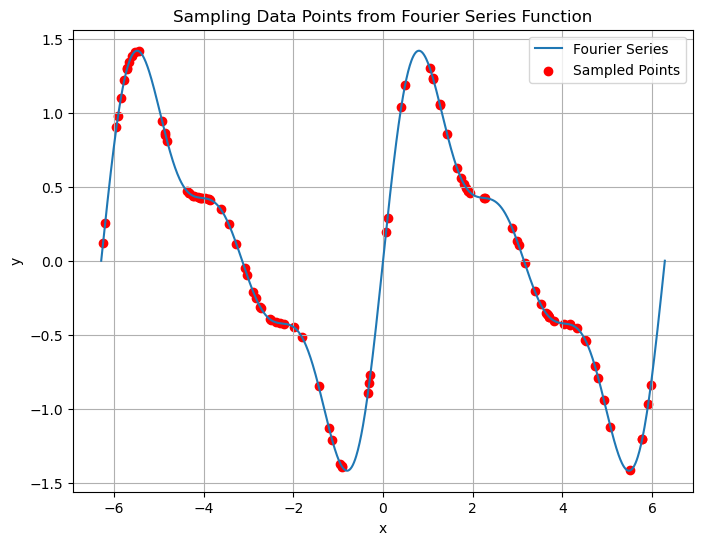

In [2]:
# Generate x values for sampling
x_min, x_max = -2*np.pi, 2*np.pi  # Range of x values for sampling
num_samples = 100  # Number of data points to sample
#x_samples = np.linspace(x_min, x_max, num_samples)  # Sample points evenly
x_samples = np.random.uniform(low=x_min, high=x_max, size=num_samples)

# Calculate y values using Fourier series at the sampled points
y_samples = np.array([fourier_series(x, coefficients) for x in x_samples])

# Print sampled data points
#print("Sampled Data Points:")
#for x, y in zip(x_samples, y_samples):
#    print(f"x = {x:.3f}, y = {y:.3f}")

# Plot the Fourier series function and sampled data points
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='Fourier Series')
plt.scatter(x_samples, y_samples, color='red', label='Sampled Points')
plt.title('Sampling Data Points from Fourier Series Function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


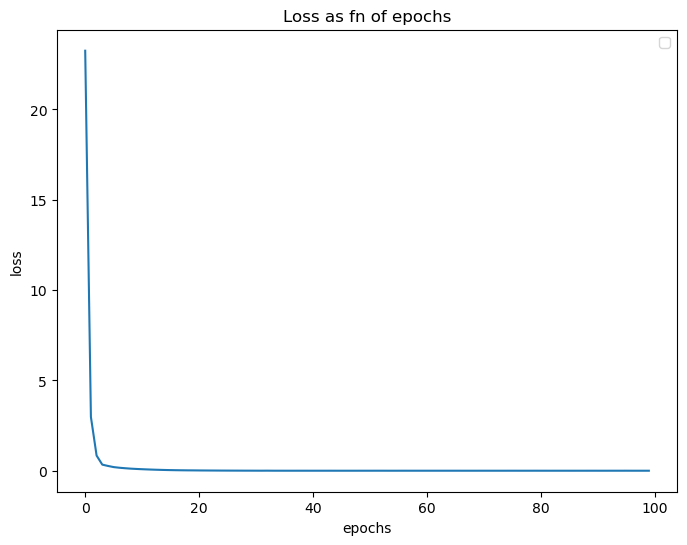

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


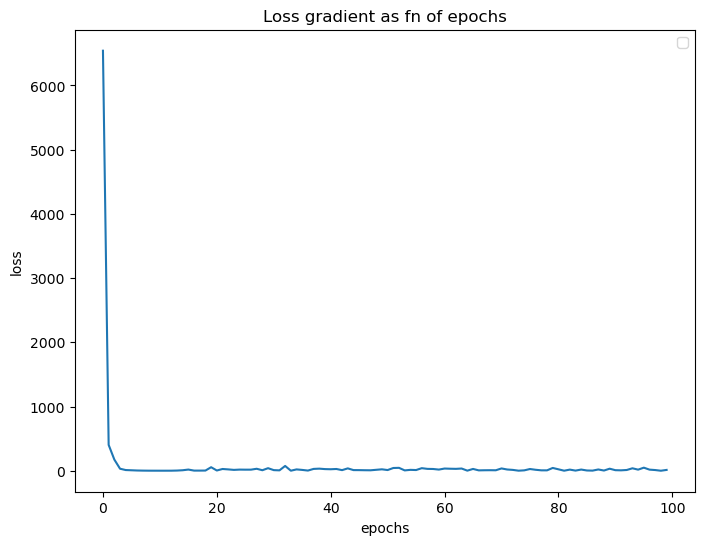

In [109]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from copy import deepcopy

# Define the Fourier series function (ground truth)
#def ground_truth_fourier_series(x):
#    return np.sin(x) + 0.5 * np.sin(2*x) + 0.3 * np.sin(3*x)

# Function to generate polynomial features from input x
def polynomial_feature_map(x, degree):
    # Create a tensor containing [0, 1, 2, ..., degree]
    powers = torch.arange(degree, dtype=x.dtype, device=x.device)

    # Compute x raised to the power of powers
    polynomial_features = x ** powers
    return polynomial_features

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.tfc = nn.Linear(input_size,output_size)
        
    def forward(self, x):
        x = polynomial_feature_map(x,self.input_size)
        #print(torch.norm(x))
        x = self.relu(self.fc1(x))
        #print(torch.norm(x))
        x = self.fc2(x)
        #print('Final',torch.norm(x))
        return x

# Convert numpy arrays to PyTorch tensors
x_train = torch.tensor(x_samples.reshape(-1, 1), dtype=torch.float32)
y_train = torch.tensor(y_samples.reshape(-1, 1), dtype=torch.float32)

# Hyperparameters
input_size = 5  # Dimension of input (x)
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 1  # Dimension of output (y)

# Initialize the MLP model
model = MLP(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()

#######################################
#### OPTIMIZERS
####################################

### SGD
SGDlr = 0.00001
SGDoptim = optim.SGD(model.parameters(), lr=SGDlr)

### Momentum
Momlr = 0.0001
momfactor = 0.8
Momoptim = optim.SGD(model.parameters(), lr=Momlr, momentum=momfactor)

### Nesterov
Neslr = 0.0001
Nesfactor = 0.8
Nesoptim = optim.SGD(model.parameters(), lr=Neslr, momentum=Nesfactor, nesterov=True)

### Adadelta
AdDlr = 0.001
AdDfactor = 0.9
AdDoptim = optim.Adadelta(model.parameters(), lr=AdDlr, rho=AdDfactor)

### ADAM
AdMlr = 0.0001
AdMfactor = (0.9, 0.99)
AdMoptim = optim.Adam(model.parameters(), lr=AdMlr, betas=AdMfactor)


optimizer = AdMoptim
num_epochs = 10000

###### Running variables ############
st_loss = []
st_lossgrad = []
st_minlossgrad = []
minloss = 1e5

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_train)
    #print(xtrain.shape,outputs.shape)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if minloss > loss.item():
        minloss = loss.item()
        st_model = deepcopy(model)
        #minlossgradnorm = torch.norm(loss.grad())
    
    if (epoch+1) % (num_epochs/100) == 0:
        st_loss.append(loss.item())
        grads = []
        for param in model.parameters():
            #print(defined(param.grad))
            if (param.grad is not None):
                grads.append(param.grad.view(-1))
        #print(torch.cat(grads))
        st_lossgrad.append(torch.norm(torch.cat(grads)))
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, norm of Grad: {torch.norm(torch.cat(grads))}')

# Plotting the results
plt.figure(figsize=(8, 6))
#print(st_loss)
plt.plot(np.asarray(st_loss))
plt.title('Loss as fn of epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Plotting the results
plt.figure(figsize=(8, 6))
#print(st_loss)
plt.plot(np.asarray(st_lossgrad))
plt.title('Loss gradient as fn of epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


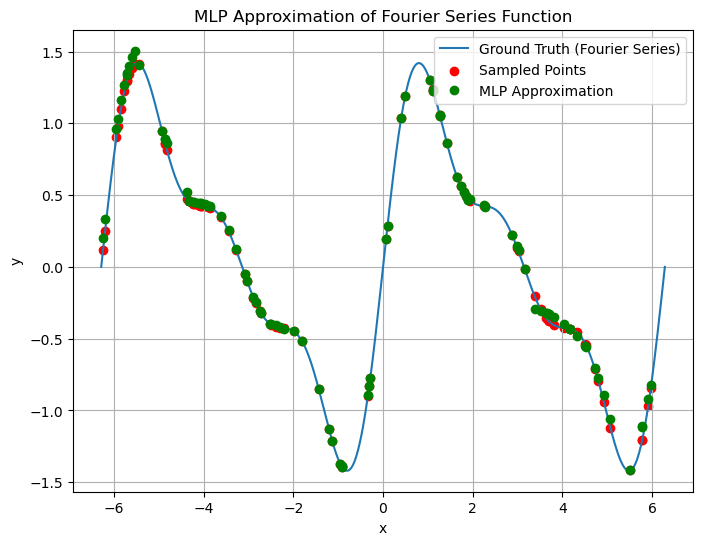

In [110]:
# Evaluate the trained model
model.eval()
with torch.no_grad():
    predicted = model(x_train)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='Ground Truth (Fourier Series)')
plt.scatter(x_samples, y_samples, color='red', label='Sampled Points')
plt.plot(x_samples, predicted.numpy(), 'go', label='MLP Approximation')
plt.title('MLP Approximation of Fourier Series Function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

